In [1]:
# importing all the required libraries
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score


In [12]:
# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Loading movie metadata
metadata = pd.read_csv("/content/movie.metadata.tsv", sep='\t', header=None)
metadata.columns = ["movie_id", "1", "movie_name", "3", "4", "5", "6", "7", "genre"]

In [14]:
# Loading movie plots
plots = []
with open("/content/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        plots.append(row)


12093it [00:00, 40267.64it/s]


In [15]:
# Extracting movie IDs
movie_ids = []
plot_summaries = []
for plot in tqdm(plots):
    movie_ids.append(plot[0])
    plot_summaries.append(plot[1])


100%|██████████| 12093/12093 [00:00<00:00, 403603.97it/s]


In [16]:
# Creating DataFrame for movies
movies = pd.DataFrame({'movie_id': movie_ids, 'plot_summary': plot_summaries})

# Changing datatype of 'movie_id'
metadata['movie_id'] = metadata['movie_id'].astype(str)


In [17]:
# Merge metadata with movies
movies = pd.merge(movies, metadata[['movie_id', 'movie_name','genre']], on='movie_id')

# Converting genre string to list
movies['genre_list'] = movies['genre'].apply(lambda x: list(json.loads(x).values()))

# Removing samples with no genre tags
movies = movies[~(movies['genre_list'].str.len() == 0)]

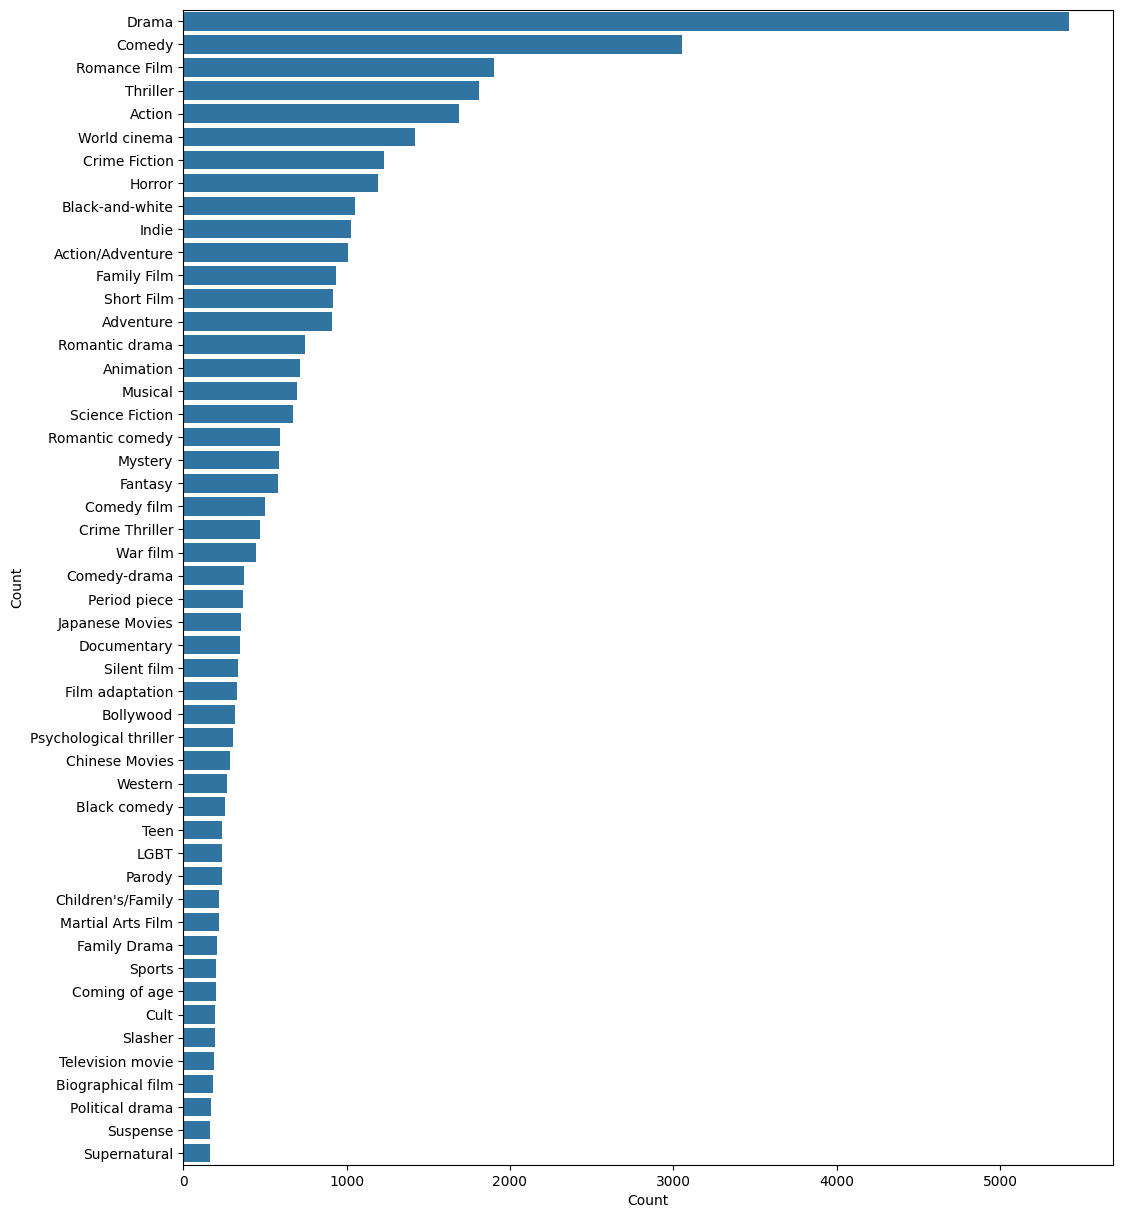

In [18]:
# Plotting the  genre distribution
all_genres = sum(movies['genre_list'], [])
genre_freq = nltk.FreqDist(all_genres)
genre_freq_df = pd.DataFrame({'Genre': list(genre_freq.keys()), 'Count': list(genre_freq.values())})
top_genres = genre_freq_df.nlargest(columns="Count", n=50)
plt.figure(figsize=(12, 15))
sns.barplot(data=top_genres, x="Count", y="Genre")
plt.ylabel('Count')
plt.show()

In [19]:
# Text preprocessing
def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)

In [20]:
#removing stopwords
movies['clean_plot'] = movies['plot_summary'].apply(remove_stopwords)

In [21]:
# Splitting data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(movies['clean_plot'], movies['genre_list'], test_size=0.2, random_state=9)

# vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Model training using Logistic Regression
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(X_train_tfidf, MultiLabelBinarizer().fit_transform(y_train))

OneVsRestClassifier(estimator=LogisticRegression())

In [22]:
# Predictions
y_pred = clf.predict(X_val_tfidf)

# MultiLabelBinarizer Fitting on y_train
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)

y_val_bin = mlb.transform(y_val)
y_pred_bin = clf.predict(X_val_tfidf)

# Calculate F1-score
f1_micro = f1_score(y_val_bin, y_pred_bin, average='micro')
print("F1-score (micro):", f1_micro)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Buddy cop', 'Computers', 'Female buddy film', 'Goat gland', 'Health & Fitness', 'Horse racing', 'Inventions & Innovations', 'Jukebox musical', 'Kafkaesque', 'Ninja movie', 'Sci-Fi Thriller', 'Singing cowboy', 'Sponsored film'] will be ignored
  warnings.warn(


F1-score (micro): 0.21739130434782608


In [23]:
def infer_genre_tags(plot_summary):
    clean_summary = remove_stopwords(plot_summary)
    summary_vec = tfidf_vectorizer.transform([clean_summary])
    genre_pred = clf.predict(summary_vec)
    return mlb.inverse_transform(genre_pred)


In [26]:
# taking 5 random samples from validation set
for _ in range(5):
    idx = X_val.sample(1).index[0]
    print("Movie:", movies['movie_name'][idx])
    print("Predicted genre:", infer_genre_tags(X_val[idx]))
    print("Actual genre:", y_val[idx])
    print()


Movie: Km. 0
Predicted genre: [('Comedy', 'Drama', 'Romance Film')]
Actual genre: ['LGBT', 'Romantic comedy', 'World cinema', 'Drama', 'Comedy', 'Romance Film']

Movie: Fortress
Predicted genre: [('Drama',)]
Actual genre: ['Action']

Movie: The Secret Cinema
Predicted genre: [()]
Actual genre: ['Short Film']

Movie: Pardon My Terror
Predicted genre: [()]
Actual genre: ['Short Film', 'Comedy']

Movie: The Narrow Margin
Predicted genre: [('Drama',)]
Actual genre: ['Thriller', 'Crime Fiction', 'Psychological thriller', 'Black-and-white', 'Mystery', 'Drama', 'Suspense', 'Crime Thriller', 'Film noir']

